<a href="https://colab.research.google.com/github/OJB-Quantum/Qiskit-Metal-to-Litho/blob/main/Qiskit_Metal_Fully_in_Google_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Headless preflight (Qt off) + deps
import os
os.environ["QT_QPA_PLATFORM"] = "offscreen"
os.environ["MPLBACKEND"] = "Agg"

import matplotlib as mpl
try:
    mpl.use("Agg", force=True)
except TypeError:
    mpl.use("Agg")
print("Matplotlib backend:", mpl.get_backend())

# Scientific + GDS toolchain (incl. Descartes)
!pip install "jedi>=0.16"
%pip -q install --upgrade pip wheel setuptools
%pip -q install "numpy>=1.24" "matplotlib>=3.8" \
                "gdstk>=0.9.61" "shapely>=2.0" "ezdxf>=1.2.0" \
                "pandas>=2.0" "scipy>=1.10" "networkx>=2.8" \
                "pint>=0.20" "addict>=2.4.0" "pyyaml>=6.0.1" \
                "qutip>=4.7" "h5py>=3.8" "descartes>=1.1" "jedi>=0.19.1"

Matplotlib backend: Agg
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 62.0 MB/s eta 0:00:00


In [2]:
#@title Clone Metal; bind to /content/qiskit-metal; headless, layout-only init (Dict + is_component)
# pylint: disable=invalid-name
import os, sys, re, textwrap
from pathlib import Path

# Fresh clone
!rm -rf /content/qiskit-metal
!git clone --depth 1 https://github.com/qiskit-community/qiskit-metal /content/qiskit-metal

root = Path("/content/qiskit-metal")
pkg  = root / "qiskit_metal"
assert pkg.exists(), f"Package folder missing: {pkg}"

# Force Python to import FROM THIS FOLDER (no editable install)
if str(root) not in sys.path:
    sys.path.insert(0, str(root))
os.environ["PYTHONPATH"] = str(root) + (":" + os.environ.get("PYTHONPATH",""))

# --- Replace qiskit_metal/__init__.py with a minimal but compatible headless init ---
orig_init = (pkg / "__init__.py").read_text(encoding="utf-8")
(pkg / "__init__orig.py").write_text(orig_init, encoding="utf-8")

minimal_init = textwrap.dedent("""
    # [colab] Headless, layout-only __init__ (no GUI, no analyses), keep essentials.
    import logging as _logging
    try:
        from addict import Dict as Dict
    except Exception:
        from .toolbox_python.attr_dict import Dict

    logger = _logging.getLogger("qiskit_metal_colab")

    class _Config:
        @staticmethod
        def is_building_docs():
            return False
    config = _Config()

    def is_design(obj):
        try:
            from .designs.design_base import QDesign
            return isinstance(obj, QDesign)
        except Exception:
            return False

    def is_component(obj):
        try:
            from .qlibrary.core.base import QComponent
            return isinstance(obj, QComponent)
        except Exception:
            return False

    __all__ = ["Dict", "config", "logger", "is_design", "is_component"]
""").strip()+"\n"
(pkg / "__init__.py").write_text(minimal_init, encoding="utf-8")

# --- Scrub ALL draw.mpl imports to avoid PySide2 at import time ---
draw_init = pkg / "draw" / "__init__.py"
if draw_init.exists():
    d = draw_init.read_text(encoding="utf-8")
    # Guard "from . import mpl"
    d = re.sub(r'^\s*from\s+\.\s*import\s+mpl\s*$',
               "try:\n    from . import mpl\n"
               "except Exception as _e:\n"
               "    print('[colab] draw.mpl disabled (headless):', _e)\n",
               d, flags=re.MULTILINE)
    # Guard "from .mpl import ..." and any other .mpl imports
    d = re.sub(r'^\s*from\s+\.\s*mpl\s+import[^\n]*$',
               "try:\n    from .mpl import render, figure_spawn\n"
               "except Exception as _e:\n"
               "    print('[colab] draw.mpl (named) disabled (headless):', _e)\n"
               "    def render(*a, **k):\n"
               "        raise RuntimeError('draw.mpl unavailable in headless mode')\n"
               "    def figure_spawn(*a, **k):\n"
               "        raise RuntimeError('draw.mpl unavailable in headless mode')\n",
               d, flags=re.MULTILINE)
    draw_init.write_text(d, encoding="utf-8")

# Optional: ensure renderers package never drags Qt; keep explicit imports only
rndr_init = pkg / "renderers" / "__init__.py"
if rndr_init.exists():
    (rndr_init.parent / "__init__orig.py").write_text(rndr_init.read_text(encoding="utf-8"), encoding="utf-8")
    rndr_init.write_text("# [colab] minimal renderers package (explicit imports only; no Qt/MPL)\n__all__ = []\n",
                         encoding="utf-8")

# Verify: import the package *from this folder* and keep it light
import importlib, sys as _sys
importlib.invalidate_caches()
import qiskit_metal
print("qiskit_metal from:", qiskit_metal.__file__)
assert qiskit_metal.__file__.startswith(str(pkg)), "Not importing from /content/qiskit-metal!"


Cloning into '/content/qiskit-metal'...
remote: Enumerating objects: 1050, done.
remote: Counting objects: 100% (1050/1050), done.
remote: Compressing objects: 100% (952/952), done.
remote: Total 1050 (delta 166), reused 673 (delta 88), pack-reused 0 (from 0)
Receiving objects: 100% (1050/1050), 30.22 MiB | 9.51 MiB/s, done.
Resolving deltas: 100% (166/166), done.
Updating files: 100% (1101/1101), done.
qiskit_metal from: /content/qiskit-metal/qiskit_metal/__init__.py


In [21]:
# -*- coding: utf-8 -*-
"""CPW with TRUE round-U meander auto-connecting two LaunchpadWirebond pads.

This single cell:
  * Builds a meandered coplanar waveguide (CPW) using gdstk.FlexPath with round turns.
  * Places the LEFT pad at a fixed location/orientation.
  * FINISHES the CPW route, then PLACES the RIGHT pad so its tie coincides with the CPW endpoint.
  * Adds a tiny overlap *toward the neck* (local −x) at each pad to guarantee polygon merging.
  * Converts all paths to polygons, unions ground cuts, subtracts from a full-chip ground plane.
  * Writes a GDS file using user-chosen units and layers.

Style, knobs, and safeguards:
  * PEP 8 / PEP 257, Google-style comments, explicit "control knobs".
  * Robust mm↔µm scaling via design.parse_value('1um') [no geometry guessing].
  * Defensive checks for pitch vs. radius feasibility.
  * Optional metal union per layer (disabled by default).

Dependencies:
  * gdstk >= 0.9.5, shapely >= 1.8, qiskit-metal (DesignPlanar and LaunchpadWirebond).
"""

import math
import os
import warnings

# Avoid Qt usage in headless environments (Qiskit Metal GUI not used here).
os.environ["QT_QPA_PLATFORM"] = "offscreen"

# ----------------------------- Dependencies -----------------------------
try:
    import gdstk  # >= 0.9
except ModuleNotFoundError:
    import sys
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "gdstk>=0.9.5"])
    import gdstk

try:
    from shapely.geometry import Polygon as ShpPolygon, MultiPolygon as ShpMultiPolygon
except ModuleNotFoundError:
    import sys
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "shapely>=1.8"])
    from shapely.geometry import Polygon as ShpPolygon, MultiPolygon as ShpMultiPolygon

try:
    from qiskit_metal.designs import DesignPlanar
    from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond
except ModuleNotFoundError:
    # qiskit-metal is large; install only if truly missing.
    import sys
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "qiskit-metal>=0.1.5"])
    from qiskit_metal.designs import DesignPlanar
    from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond


# ============================================================================
#                               CONTROL KNOBS
# ============================================================================

# CPW geometry (µm)
CPW_WIDTH_UM: float = 10.0       # center trace width
CPW_GAP_UM: float = 6.0          # each-side gap

# Meander (∪ ∪ ∪ … along +x)
N_LOBES: int | None = 10          # fixed number of U-turn lobes (None => not auto-fitted here)
PITCH_UM: float = 450.0          # center-to-center advance per lobe along +x
RADIUS_UM: float = 160.0         # bend radius for the 90°/180° turns; must satisfy 2R < PITCH - width

# Leads (straight runs before first U and after last U, both measured along +x)
LEAD_START_UM: float = 200.0
LEAD_END_UM: float = 200.0

# Small overlaps so the meander metal merges into pad necks (toward the neck = local −x)
START_OVERLAP_UM: float = 5.0
END_OVERLAP_UM: float = 5.0

# Chip size (any unit strings acceptable to Qiskit Metal, default design units are mm)
CHIP_SIZE_X: str = "9mm"
CHIP_SIZE_Y: str = "4mm"

# Launch pad parameters
PAD_WIDTH_UM: float = 300.0
TAPER_HEIGHT_UM: float = 300.0
PAD_HEIGHT_UM: float = 240.0
PAD_GAP_UM: float = 144.0
LEAD_LEN_UM: float = 50.0

# LEFT pad placement (fixed). RIGHT pad is computed from CPW endpoint automatically.
LP_LEFT_X_UM: float = 0.0
LP_Y_UM: float = 0.0
LP_LEFT_ORIENTATION_DEG: float = 0.0
RIGHT_PAD_ORIENTATION_DEG: float = 180.0  # Typically faces left to meet a +x-running CPW.

# GDS output
GDS_OUT: str = "/content/meander_with_ground_gdstk.gds"
GDS_TOP_CELL: str = "TOP"
GDS_UNIT: float = 1e-6
GDS_PRECISION: float = 1e-9

# Layers and datatypes
LAYER_METAL: int = 1
LAYER_GROUND: int = 2
DT: int = 0

# Optional: union all METAL polygons per layer before writing (kept False by default).
UNION_METAL: bool = False


# ============================================================================
#                              HELPER FUNCTIONS
# ============================================================================

def _unit_scale_um_per_du(design: DesignPlanar) -> float:
    """Return µm per Design Unit (DU), robust to the configured base unit.

    With default design units of millimeters, design.parse_value('1um') == 0.001 (mm),
    so µm per DU is 1 / 0.001 = 1000.
    """
    # NOTE: We rely on Qiskit Metal's parser rather than deducing from geometry.
    # Ref: design.parse_value docs.
    um_in_du = float(design.parse_value("1um"))  # value expressed in DU
    return 1.0 / um_in_du  # µm / DU


def _to_um(design: DesignPlanar, value: str | float) -> float:
    """Parse a Qiskit value string/number to microns (µm)."""
    return float(design.parse_value(value)) * _unit_scale_um_per_du(design)


def _as_polygons_um(geom, um_per_du: float) -> list[tuple[list[tuple[float, float]], list[list[tuple[float, float]]]]]:
    """Convert shapely geometry (in DU) to list of (outer, holes) scaled to µm."""
    out: list[tuple[list[tuple[float, float]], list[list[tuple[float, float]]]]] = []
    if isinstance(geom, ShpPolygon):
        seq = [(geom.exterior, list(geom.interiors))]
    elif isinstance(geom, ShpMultiPolygon):
        seq = [(p.exterior, list(p.interiors)) for p in geom.geoms]
    else:
        return out

    for ext, holes in seq:
        outer = [(float(x) * um_per_du, float(y) * um_per_du) for (x, y) in ext.coords]
        hole_list = [[(float(x) * um_per_du, float(y) * um_per_du) for (x, y) in h.coords] for h in holes]
        out.append((outer, hole_list))
    return out


def _bbox(polys_by_layer: dict[int, list[tuple[list[tuple[float, float]], list[list[tuple[float, float]]]]]]
          ) -> tuple[float, float, float, float]:
    """Axis-aligned bounding box of a dict-of-polygons bucket."""
    import math as _m
    minx = miny = _m.inf
    maxx = maxy = -_m.inf
    for plist in polys_by_layer.values():
        for outer, _holes in plist:
            if not outer:
                continue
            xs, ys = zip(*outer)
            minx = min(minx, min(xs)); maxx = max(maxx, max(xs))
            miny = min(miny, min(ys)); maxy = max(maxy, max(ys))
    return (minx, miny, maxx, maxy)


def _shift(polys_by_layer: dict[int, list[tuple[list[tuple[float, float]], list[list[tuple[float, float]]]]]],
           dx: float, dy: float) -> None:
    """Translate a dict-of-polygons bucket by (dx, dy) in µm."""
    for lyr, plist in list(polys_by_layer.items()):
        for i, (outer, holes) in enumerate(plist):
            outer2 = [(x - dx, y - dy) for (x, y) in outer]
            holes2 = [[(x - dx, y - dy) for (x, y) in h] for h in holes]
            plist[i] = (outer2, holes2)
        polys_by_layer[lyr] = plist


# ============================================================================
#                                MAIN SCRIPT
# ============================================================================

# -- Create design (no GUI) and set base CPW variables used by LaunchpadWirebond
design = DesignPlanar(metadata={}, overwrite_enabled=True, enable_renderers=False)
design.variables["cpw_width"] = f"{CPW_WIDTH_UM}um"
design.variables["cpw_gap"] = f"{CPW_GAP_UM}um"
design.chips.main.size["size_x"] = CHIP_SIZE_X
design.chips.main.size["size_y"] = CHIP_SIZE_Y

UM_PER_DU = _unit_scale_um_per_du(design)

# -- LEFT pad (fixed placement). The right pad will be placed *after* the meander.
lpL = LaunchpadWirebond(
    design,
    "LP_left",
    options=dict(
        pos_x=f"{LP_LEFT_X_UM}um",
        pos_y=f"{LP_Y_UM}um",
        orientation=str(int(LP_LEFT_ORIENTATION_DEG)),
        trace_width=f"{CPW_WIDTH_UM}um",
        trace_gap=f"{CPW_GAP_UM}um",
        lead_length=f"{LEAD_LEN_UM}um",
        pad_width=f"{PAD_WIDTH_UM}um",
        pad_height=f"{PAD_HEIGHT_UM}um",
        pad_gap=f"{PAD_GAP_UM}um",
        taper_height=f"{TAPER_HEIGHT_UM}um",
    ),
)

# -- Extract left tie (starting point) in µm
xL_d, y0_d = map(float, lpL.pins["tie"]["middle"])
xL_um, y0_um = xL_d * UM_PER_DU, y0_d * UM_PER_DU

# -- Build the meander path + its "gap envelope" as a second path
path = gdstk.FlexPath(
    [(xL_um, y0_um)],
    CPW_WIDTH_UM,
    joins="round",
    ends="flush",
    simple_path=True,
    tolerance=1e-3,
    layer=LAYER_METAL,
    datatype=DT,
)
penv = gdstk.FlexPath(
    [(xL_um, y0_um)],
    CPW_WIDTH_UM + 2.0 * CPW_GAP_UM,
    joins="round",
    ends="flush",
    simple_path=True,
    tolerance=1e-3,
    layer=LAYER_GROUND,
    datatype=DT,
)

# -- Initial overlap toward left pad neck (local −x) then proceed along +x
theta_L = math.radians(LP_LEFT_ORIENTATION_DEG)
ux_L, uy_L = (math.cos(theta_L), math.sin(theta_L))
# Step a tiny bit into the neck:
path.segment((xL_um - ux_L * START_OVERLAP_UM, y0_um - uy_L * START_OVERLAP_UM))
penv.segment((xL_um - ux_L * START_OVERLAP_UM, y0_um - uy_L * START_OVERLAP_UM))
# Then head to the right by LEAD_START_UM:
path.segment((xL_um + LEAD_START_UM, y0_um))
penv.segment((xL_um + LEAD_START_UM, y0_um))

# -- Ensure radius is feasible for the chosen pitch and width
if 2.0 * RADIUS_UM >= (PITCH_UM - CPW_WIDTH_UM):
    RADIUS_UM = max(1.0, 0.5 * (PITCH_UM - CPW_WIDTH_UM) - 1.0)

# -- Lobe count (we keep explicit N; auto-fit requires a target span which we no longer use)
N = max(1, int(N_LOBES if N_LOBES is not None else 1))

# -- Straight advance per lobe excluding the 2*R contributed by the round U-turn
step_dx = max(0.0, PITCH_UM - 2.0 * RADIUS_UM)

# -- Draw N true ∪ lobes; each lobe ends heading +x
for _ in range(N):
    if step_dx > 0:
        path.horizontal(step_dx, relative=True)
        penv.horizontal(step_dx, relative=True)
    R = float(RADIUS_UM)
    path.turn(R, -math.pi / 2.0); penv.turn(R, -math.pi / 2.0)  # down 90°
    path.turn(R,  math.pi);        penv.turn(R,  math.pi)        # bottom 180°
    path.turn(R, -math.pi / 2.0); penv.turn(R, -math.pi / 2.0)  # up 90° → +x

# -- Lead-out before placing the right pad (purely aesthetic)
path.horizontal(LEAD_END_UM, relative=True)
penv.horizontal(LEAD_END_UM, relative=True)

# -- Endpoint and heading of the CPW spine (last two points)
sp = path.spine()
end_x_um, end_y_um = (float(sp[-1, 0]), float(sp[-1, 1]))
pre_x_um, pre_y_um = (float(sp[-2, 0]), float(sp[-2, 1]))
vx, vy = (end_x_um - pre_x_um, end_y_um - pre_y_um)  # not normalized; here typically ~(+1, 0)

# -- Place RIGHT pad so that its tie equals the CPW endpoint
theta_R = math.radians(RIGHT_PAD_ORIENTATION_DEG)
ux_R, uy_R = (math.cos(theta_R), math.sin(theta_R))  # local +x of the right pad
posR_x_um = end_x_um - LEAD_LEN_UM * ux_R
posR_y_um = end_y_um - LEAD_LEN_UM * uy_R

lpR = LaunchpadWirebond(
    design,
    "LP_right",
    options=dict(
        pos_x=f"{posR_x_um}um",
        pos_y=f"{posR_y_um}um",
        orientation=str(int(RIGHT_PAD_ORIENTATION_DEG)),
        trace_width=f"{CPW_WIDTH_UM}um",
        trace_gap=f"{CPW_GAP_UM}um",
        lead_length=f"{LEAD_LEN_UM}um",
        pad_width=f"{PAD_WIDTH_UM}um",
        pad_height=f"{PAD_HEIGHT_UM}um",
        pad_gap=f"{PAD_GAP_UM}um",
        taper_height=f"{TAPER_HEIGHT_UM}um",
    ),
)
lpR.rebuild()  # ensure qgeometry tables reflect the new placement

# -- Recompute right tie (should match endpoint) and add a tiny overlap toward the neck (local −x)
xR_d, yR_d = map(float, lpR.pins["tie"]["middle"])
xR_um, yR_um = (xR_d * UM_PER_DU, yR_d * UM_PER_DU)
# Nudge into the neck (toward −local x):
path.segment((end_x_um - ux_R * END_OVERLAP_UM, end_y_um - uy_R * END_OVERLAP_UM))
penv.segment((end_x_um - ux_R * END_OVERLAP_UM, end_y_um - uy_R * END_OVERLAP_UM))

# ============================================================================
#                           PATHS → POLYGONS (baked)
# ============================================================================

metal_by_layer: dict[int, list[tuple[list[tuple[float, float]], list[list[tuple[float, float]]]]]] = {LAYER_METAL: []}
cuts_by_layer: dict[int, list[tuple[list[tuple[float, float]], list[list[tuple[float, float]]]]]] = {LAYER_GROUND: []}

# From gdstk FlexPath into simple polygon vertex lists (using .points)
for poly in path.to_polygons():
    pts = getattr(poly, "points", poly)
    metal_by_layer[LAYER_METAL].append(([(float(px), float(py)) for px, py in pts], []))
for poly in penv.to_polygons():
    pts = getattr(poly, "points", poly)
    cuts_by_layer[LAYER_GROUND].append(([(float(px), float(py)) for px, py in pts], []))

# Add pad bodies from Qiskit Metal (DU → µm)
polytab = design.qgeometry.tables.get("poly")
if polytab is not None and len(polytab):
    for _, row in polytab.iterrows():
        lyr = int(row.get("layer", LAYER_METAL))
        subtract = bool(row.get("subtract", False))
        geom = row.get("geometry", None)
        for outer, holes in _as_polygons_um(geom, UM_PER_DU):
            (cuts_by_layer if subtract else metal_by_layer).setdefault(lyr, []).append((outer, holes))

# Center the whole layout around (0,0) for a neat chip frame
import math as _m
if metal_by_layer:
    minx, miny, maxx, maxy = _bbox(metal_by_layer)
    if all(map(_m.isfinite, (minx, miny, maxx, maxy))) and (maxx > minx) and (maxy > miny):
        cx_um = 0.5 * (minx + maxx); cy_um = 0.5 * (miny + maxy)
        _shift(metal_by_layer, cx_um, cy_um)
        _shift(cuts_by_layer,  cx_um, cy_um)

# ============================================================================
#                                 WRITE GDS
# ============================================================================

lib = gdstk.Library(unit=GDS_UNIT, precision=GDS_PRECISION)
top = lib.new_cell(GDS_TOP_CELL)

# Chip rectangle in µm (parsed via design.parse_value)
sx_um = _to_um(design, design.chips.main.size["size_x"])
sy_um = _to_um(design, design.chips.main.size["size_y"])
chip_rect = gdstk.rectangle(
    (-sx_um / 2.0, -sy_um / 2.0),
    (sx_um / 2.0, sy_um / 2.0),
    layer=LAYER_GROUND,
    datatype=DT,
)

# Build union of cuts (CPW gaps + pad pockets) and subtract from the chip ground
all_cuts = [gdstk.Polygon(outer, layer=LAYER_GROUND, datatype=DT)
            for _, plist in cuts_by_layer.items()
            for (outer, _holes) in plist]

if all_cuts:
    cuts_union = gdstk.boolean(all_cuts, [], "or", precision=5e-3, layer=LAYER_GROUND, datatype=DT)
    ground_effective = gdstk.boolean([chip_rect], cuts_union, "not", precision=5e-3,
                                     layer=LAYER_GROUND, datatype=DT)
else:
    ground_effective = [chip_rect]

for g in ground_effective or []:
    top.add(gdstk.Polygon(g.points, layer=LAYER_GROUND, datatype=DT))

# Optionally union metal per layer before writing (helps some fab flows)
if UNION_METAL:
    for lyr, plist in list(metal_by_layer.items()):
        polys = [gdstk.Polygon(outer, layer=lyr, datatype=DT) for (outer, _holes) in plist]
        if polys:
            united = gdstk.boolean(polys, [], "or", precision=5e-3, layer=lyr, datatype=DT) or []
            for u in united:
                top.add(gdstk.Polygon(u.points, layer=lyr, datatype=DT))
else:
    for lyr, plist in metal_by_layer.items():
        for outer, holes in plist:
            if holes:
                outer_poly = gdstk.Polygon(outer, layer=lyr, datatype=DT)
                holes_union = gdstk.boolean(
                    [gdstk.Polygon(h, layer=lyr) for h in holes], [],
                    "or", precision=5e-3, layer=lyr, datatype=DT
                )
                res = gdstk.boolean([outer_poly], holes_union, "not", precision=5e-3, layer=lyr, datatype=DT)
                for r in (res or []):
                    top.add(r)
            else:
                top.add(gdstk.Polygon(outer, layer=lyr, datatype=DT))

lib.write_gds(GDS_OUT)
print(
    "[OK] GDS written \u2192 {} | scale={:.6f} \u00B5m/DU | lobes={} | pitch={} \u00B5m | R={} \u00B5m | "
    "right_pad_orientation={} deg".format(
        GDS_OUT, UM_PER_DU, N, PITCH_UM, RADIUS_UM, int(RIGHT_PAD_ORIENTATION_DEG)
    )
)

warnings.filterwarnings("ignore", message=r"The behavior of DataFrame concatenation .* is deprecated")


[OK] GDS written → /content/meander_with_ground_gdstk.gds | scale=1000.000000 µm/DU | lobes=8 | pitch=450.0 µm | R=160.0 µm | right_pad_orientation=180 deg


[load] Reading: /content/meander_with_ground_gdstk.gds
[info] Using requested cell: TOP
[info] Bounds (µm): x[-4500.000, 4500.000], y[-2000.000, 2000.000]
[ok] wrote PNG: /content/meander_with_ground_gdstk_preview_1200dpi.png
[ok] wrote PDF: /content/meander_with_ground_gdstk_preview.pdf


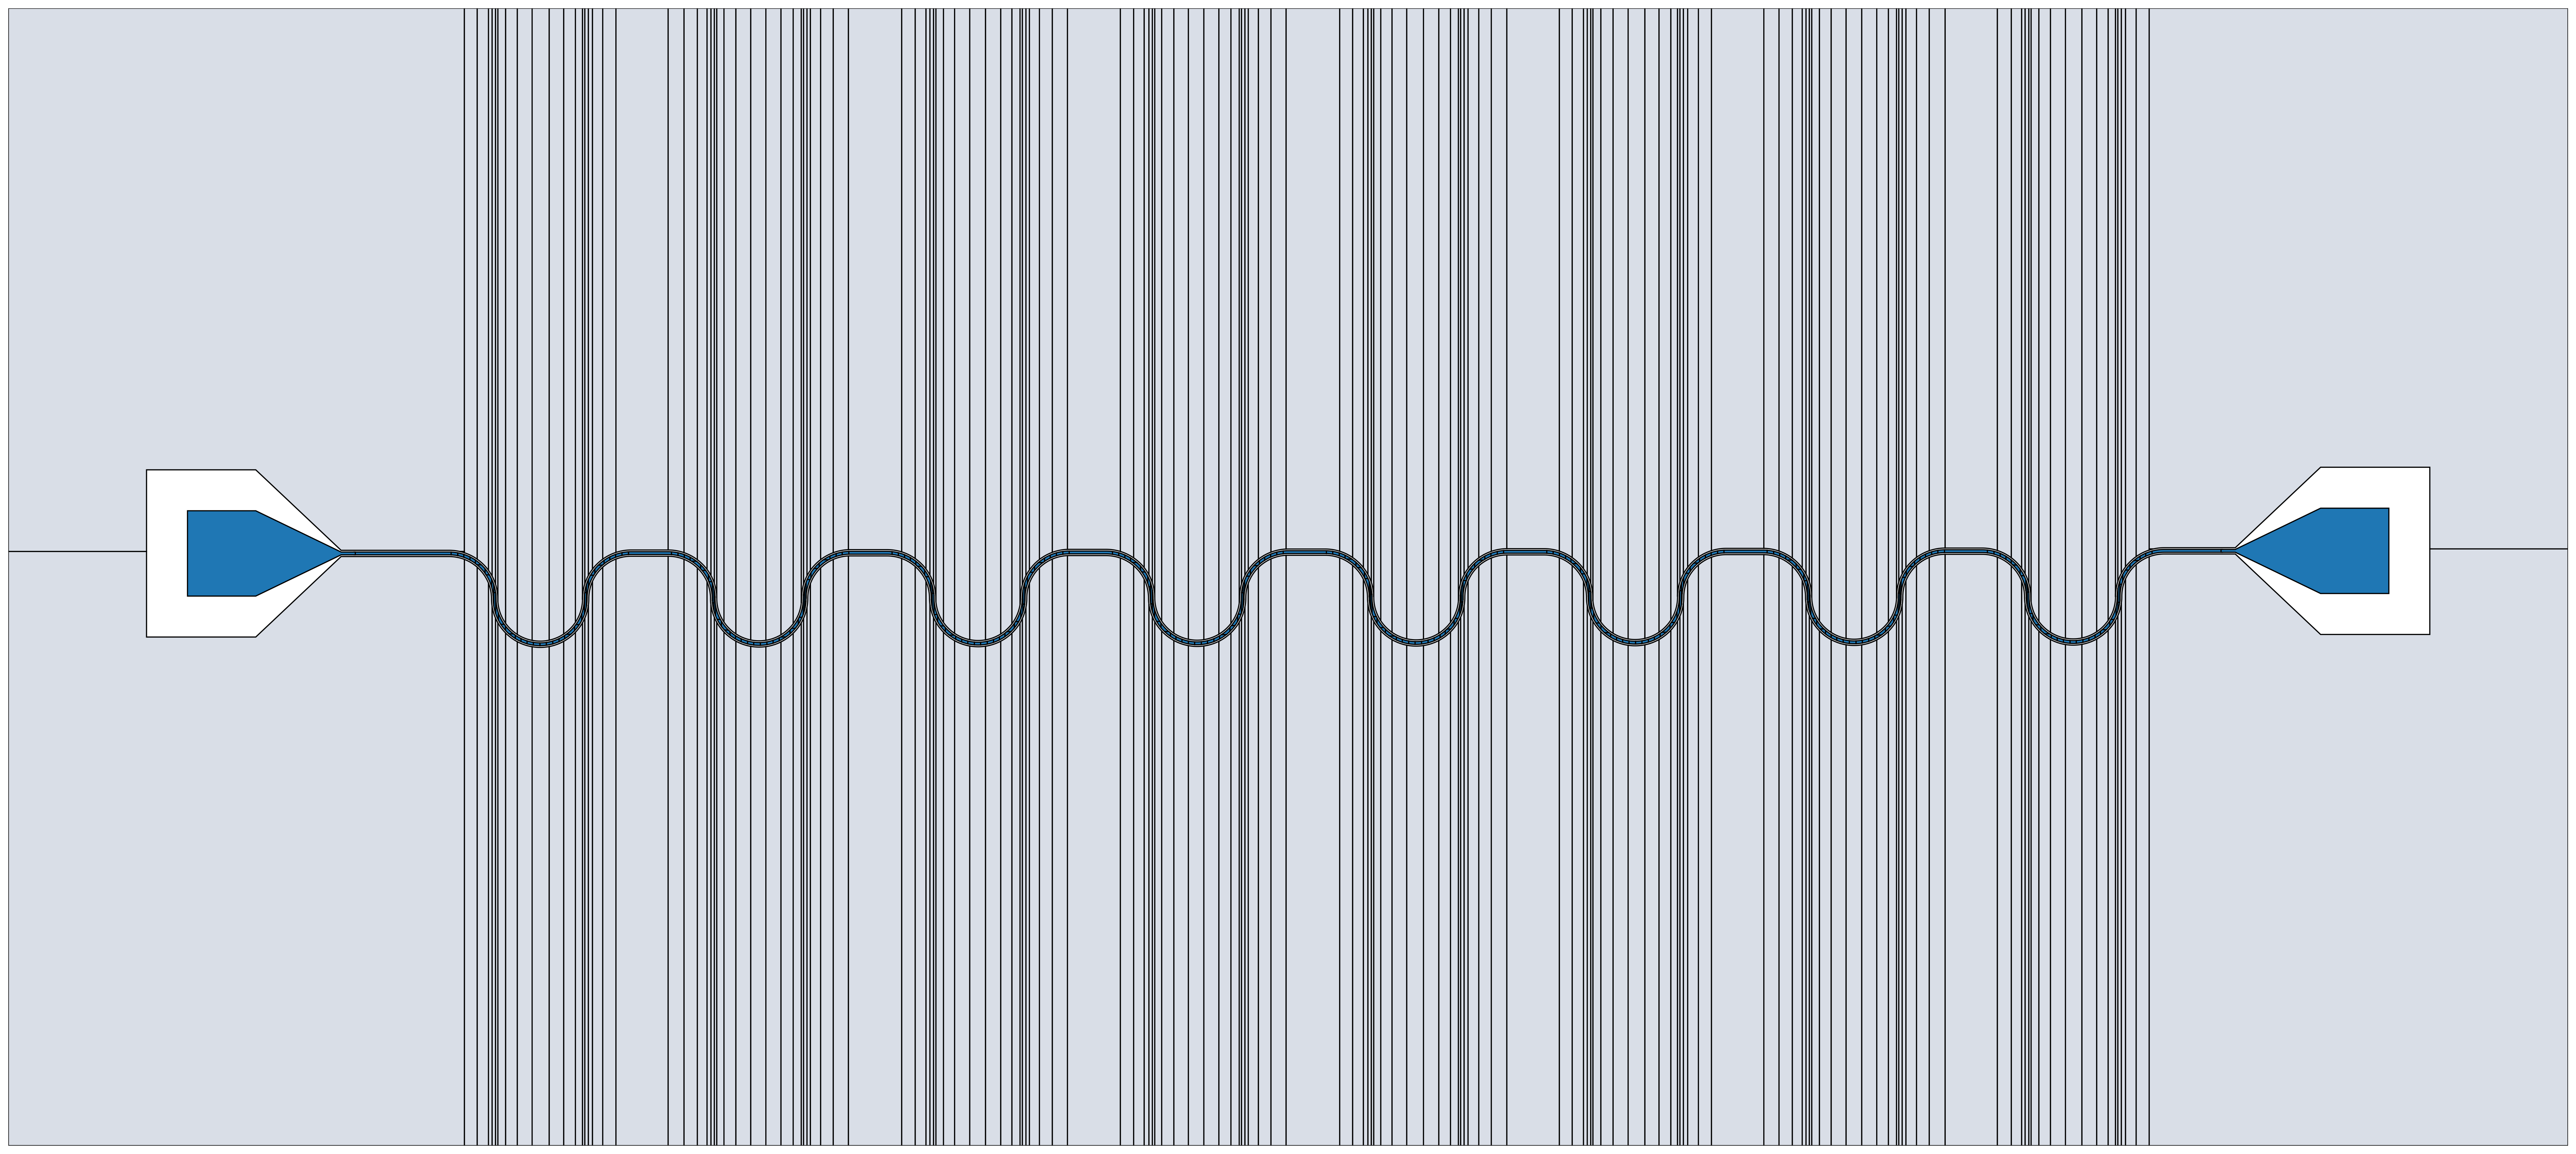

In [22]:
#@title Preview GDS inline
import os, glob, numpy as np, matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from IPython.display import display, Image
import gdstk

# ----- knobs you can tweak -----
GDS_PATH      = globals().get("GDS_OUT", "/content/meander_with_ground_gdstk.gds")  # reuse if set
TOP_CELL_NAME = globals().get("GDS_TOP_CELL", None)                                  # reuse if set
DPI           = 1200
FIG_WIDTH_IN  = 8.0
LINEWIDTH_PT  = 0.20
BG_COLOR      = "white"

# Layer colors (extend as needed)
LAYER_GROUND  = 2
LAYER_METAL   = 1
LAYER_COLOR   = {LAYER_GROUND: "#d9dee7", LAYER_METAL: "#1f77b4"}

def _pick_cell(lib, name=None):
    if name and name in [c.name for c in lib.cells]:
        print(f"[info] Using requested cell: {name}")
        return lib[name]
    tops = lib.top_level()
    if not tops:
        raise RuntimeError("No top-level cells in library.")
    print(f"[info] Auto-picked top cell: {tops[0].name}")
    return tops[0]

def _polys_by_layer(cell):
    # include_paths=True expands PATHs to polygons; apply_repetitions=True follows array/repetition
    polys = cell.get_polygons(apply_repetitions=True, include_paths=True, depth=None)
    by_layer, xs, ys = {}, [], []
    for p in polys:  # gdstk.Polygon objects
        layer = int(getattr(p, "layer", 0))
        pts = np.asarray(p.points, dtype=float)
        by_layer.setdefault(layer, []).append(pts)
        xs.append(pts[:, 0]); ys.append(pts[:, 1])
    if not xs:
        raise RuntimeError("Found no polygons to plot (empty cell?).")
    xs = np.concatenate(xs); ys = np.concatenate(ys)
    return by_layer, (float(xs.min()), float(ys.min()), float(xs.max()), float(ys.max()))

def save_and_show(gds_path, top_cell_name=None, dpi=DPI, fig_w_in=FIG_WIDTH_IN, lw_pt=LINEWIDTH_PT):
    if not os.path.exists(gds_path):
        # try last written .gds in /content
        cand = sorted(glob.glob("/content/*.gds"), key=os.path.getmtime)[-1:] or []
        if not cand:
            raise FileNotFoundError(f"GDS not found: {gds_path}")
        print(f"[warn] {gds_path} not found. Using most recent: {cand[0]}")
        gds_path = cand[0]

    print(f"[load] Reading: {gds_path}")
    lib  = gdstk.read_gds(gds_path)                                   # loads the library
    cell = _pick_cell(lib, top_cell_name)                              # choose cell
    by_layer, (minx, miny, maxx, maxy) = _polys_by_layer(cell)         # collect polys + bounds
    print(f"[info] Bounds (µm): x[{minx:.3f}, {maxx:.3f}], y[{miny:.3f}, {maxy:.3f}]")

    w_um = maxx - minx; h_um = maxy - miny
    aspect = w_um / max(h_um, 1e-12); fig_h_in = fig_w_in / aspect

    fig, ax = plt.subplots(figsize=(fig_w_in, fig_h_in), dpi=dpi)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(minx, maxx); ax.set_ylim(miny, maxy)
    ax.set_facecolor(BG_COLOR); ax.axis("off")

    # Draw ground first, then metal, then others for determinism
    draw_order = sorted(by_layer.keys(), key=lambda L: (L != LAYER_GROUND, L))
    for layer in draw_order:
        face = LAYER_COLOR.get(layer, "#666666")
        for pts in by_layer[layer]:
            ax.add_patch(MplPolygon(pts, closed=True, facecolor=face, edgecolor="black",
                                    linewidth=lw_pt, antialiased=True))

    root, _ = os.path.splitext(gds_path)
    out_png = f"{root}_preview_{dpi}dpi.png"
    out_pdf = f"{root}_preview.pdf"

    # Ensure renderer computes extents before saving
    fig.canvas.draw()
    fig.savefig(out_png, dpi=dpi, bbox_inches="tight", pad_inches=0.02)  # 600-DPI PNG
    fig.savefig(out_pdf,            bbox_inches="tight", pad_inches=0.02)  # vector PDF
    print(f"[ok] wrote PNG: {out_png}")
    print(f"[ok] wrote PDF: {out_pdf}")

    # Show inline in the notebook (forces frontend display)
    display(Image(filename=out_png))
    return out_png, out_pdf

png_path, pdf_path = save_and_show(GDS_PATH, top_cell_name=TOP_CELL_NAME)


In [66]:
# -*- coding: utf-8 -*-
"""Alternating-lobe, length-faithful CPW meander that connects into both pads,
respects a minimum pad spacing, and redistributes lobe spacing with edge buffers.

Key points:
- We start slightly inside the left neck, pass through the left 'tie', and finish by
  snapping to the right 'tie' then nudging into the right neck (pad continuity).
- With fixed bend radius R and fixed lobe count N, vertical stems are solved to hit
  TARGET_LENGTH_UM exactly, independent of how horizontal pitch is distributed.
- Lobe spacing is auto-distributed: we reserve EDGE_BUFFER_UM on both ends to keep
  arcs away from tapers, then spread extra horizontal straight equally across lobes.
- The minimum legal span S_min = leads + N*(2R + MIN_STRAIGHT) is enforced by
  clamping the right pad if needed.

References:
  • gdstk FlexPath/Curve primitives: horizontal(), vertical(), turn()  [docs]
  • LaunchpadWirebond: the pin 'tie' attaches at the midpoint of the built-in lead
  • Qiskit Metal parse_value: official unit parser (mm↔µm, expressions)
"""

from __future__ import annotations

import math
import os
import warnings
from typing import Literal

# Headless-safe.
os.environ["QT_QPA_PLATFORM"] = "offscreen"

# ----------------------------- Dependencies -----------------------------
try:
    import gdstk  # ≥ 0.9.5
except ModuleNotFoundError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "gdstk>=0.9.5"])
    import gdstk

try:
    from shapely.geometry import Polygon as ShpPolygon, MultiPolygon as ShpMultiPolygon
except ModuleNotFoundError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "shapely>=1.8"])
    from shapely.geometry import Polygon as ShpPolygon, MultiPolygon as ShpMultiPolygon

try:
    from qiskit_metal.designs import DesignPlanar
    from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond
except ModuleNotFoundError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "qiskit-metal>=0.1.5"])
    from qiskit_metal.designs import DesignPlanar
    from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond


# ============================================================================
#                               CONTROL KNOBS
# ============================================================================

# CPW cross-section (µm)
CPW_WIDTH_UM: float = 10.0
CPW_GAP_UM: float = 6.0

# Target length BETWEEN pad ties (µm).  (Tiny pad overlaps are added after tying.)
TARGET_LENGTH_UM: float = 3000.0
LENGTH_TOL_UM: float = 1e-3

# Meander geometry
RADIUS_UM: float = 160.0          # fixed U-bend radius
N_LOBES: int = 1                  # alternates up/down automatically
MIN_STRAIGHT_UM: float = 6.0      # min in-lobe straight between the two quarter-turns

# Alternation control
FIRST_LOBE_POLARITY: Literal["down", "up"] = "down"

# Lead-ins/outs (counted inside the tie-to-tie span S)
LEAD_START_UM: float = 0.0
LEAD_END_UM: float = 0.0

# Keep arcs clear of the pad tapers
EDGE_BUFFER_UM: float = 50.0      # extra horizontal straight before 1st and after last lobe

# Pad-spacing enforcement
ENFORCE_MIN_SPAN: bool = True
SPAN_POLICY: Literal["clamp", "error"] = "clamp"   # when S_req < S_min

# Length feasibility policy if target < minimal length (with h=0)
STRICT_LENGTH: Literal["raise", "clip_to_min"] = "raise"

# Tiny pad-neck overlaps (toward −local x) to guarantee metal merge
START_OVERLAP_UM: float = 5.0
END_OVERLAP_UM: float = 5.0

# Chip size (Qiskit Metal parses units; default base unit is mm)
CHIP_SIZE_X: str = "8mm"
CHIP_SIZE_Y: str = "4mm"

# Launchpad geometry (µm)
PAD_WIDTH_UM: float = 300.0
TAPER_HEIGHT_UM: float = 300.0
PAD_HEIGHT_UM: float = 240.0
PAD_GAP_UM: float = 144.0
LEAD_LEN_UM: float = 50.0

# Pad placements (right pad ≈ 2 mm to the right)
LP_LEFT_X_UM: float = 0.0
LP_RIGHT_X_UM: float = 2000.0
LP_Y_UM: float = 0.0
LP_LEFT_ORIENTATION_DEG: float = 0.0
LP_RIGHT_ORIENTATION_DEG: float = 180.0

# GDS settings
GDS_OUT: str = "/content/meander_alt_updown_connected.gds"
GDS_TOP_CELL: str = "TOP"
GDS_UNIT: float = 1e-6
GDS_PRECISION: float = 1e-9

# Layers
LAYER_METAL: int = 1
LAYER_GROUND: int = 2
DT: int = 0
UNION_METAL: bool = False


# ============================================================================
#                              HELPER FUNCTIONS
# ============================================================================

def _um_per_du(design: DesignPlanar) -> float:
    """Microns per design unit (DU) via Qiskit Metal's parser."""
    val_du = float(design.parse_value("1um"))  # robust to base-unit choice
    return 1.0 / val_du

def _to_um(design: DesignPlanar, value: str | float) -> float:
    return float(design.parse_value(value)) * _um_per_du(design)

def _as_polygons_um(geom, um_per_du: float):
    out = []
    if isinstance(geom, ShpPolygon):
        seq = [(geom.exterior, list(geom.interiors))]
    elif isinstance(geom, ShpMultiPolygon):
        seq = [(p.exterior, list(p.interiors)) for p in geom.geoms]
    else:
        return out
    for ext, holes in seq:
        outer = [(float(x) * um_per_du, float(y) * um_per_du) for (x, y) in ext.coords]
        hole_list = [[(float(x) * um_per_du, float(y) * um_per_du) for (x, y) in h.coords] for h in holes]
        out.append((outer, hole_list))
    return out

def _bbox(bucket):
    import math as _m
    minx = miny = _m.inf
    maxx = maxy = -_m.inf
    for plist in bucket.values():
        for outer, _holes in plist:
            if not outer:
                continue
            xs, ys = zip(*outer)
            minx = min(minx, min(xs)); maxx = max(maxx, max(xs))
            miny = min(miny, min(ys)); maxy = max(maxy, max(ys))
    return (minx, miny, maxx, maxy)

def _shift(bucket, dx, dy):
    for lyr, plist in list(bucket.items()):
        for i, (outer, holes) in enumerate(plist):
            outer2 = [(x - dx, y - dy) for (x, y) in outer]
            holes2 = [[(x - dx, y - dy) for (x, y) in h] for h in holes]
            plist[i] = (outer2, holes2)
        bucket[lyr] = plist

def _min_span_required(N: int, R: float, min_straight: float, ls: float, le: float, edge_buf: float) -> float:
    """Minimum legal tie-to-tie span S_min for given N, R, MIN_STRAIGHT, and EDGE_BUFFER."""
    return float(ls) + float(le) + 2.0 * float(edge_buf) + max(0, int(N)) * (2.0 * float(R) + float(min_straight))

def _clamp_right_pad_to_span(lp_right: LaunchpadWirebond,
                             tie_left_x_um: float,
                             tie_left_y_um: float,
                             desired_span_um: float,
                             lead_len_um: float,
                             orientation_deg: float) -> None:
    """Move RIGHT pad so its tie is at (x_L + desired_span, y_L), orientation-aware."""
    theta = math.radians(float(orientation_deg))
    ux, uy = (math.cos(theta), math.sin(theta))  # local +x
    tie_x = tie_left_x_um + float(desired_span_um)
    tie_y = tie_left_y_um
    pos_x_um = tie_x - float(lead_len_um) * ux
    pos_y_um = tie_y - float(lead_len_um) * uy
    lp_right.options["pos_x"] = f"{pos_x_um}um"
    lp_right.options["pos_y"] = f"{pos_y_um}um"
    lp_right.rebuild()

def _solve_stems_fixed_R(
    S: float, L_target: float, N: int, R: float, ls: float, le: float,
    min_straight: float, strict_length: Literal["raise", "clip_to_min"]
) -> tuple[float, float, float, float]:
    """Return (h, L_min, L_hit, K) for fixed R,N and given S, leads."""
    N = max(0, int(N))
    K = (2.0 * math.pi - 2.0)
    L_min = S + N * K * R  # stems h=0
    if L_target < L_min - LENGTH_TOL_UM:
        if strict_length == "raise":
            raise ValueError(
                f"TARGET_LENGTH_UM={L_target:.3f} µm is below minimal L_min={L_min:.3f} µm "
                f"for (N={N}, R={R:.3f}, S={S:.3f}). Increase TARGET or reduce N/R."
            )
        L_target = L_min
    h = 0.5 * ((L_target - S) / max(1, N) - K * R) if N > 0 else 0.0
    if h < 0.0:
        h = 0.0
    L_hit = S + N * (K * R + 2.0 * h)
    return h, L_min, L_hit, K

def _draw_lobe(path: gdstk.FlexPath, penv: gdstk.FlexPath,
               R: float, step_dx: float, h: float, polarity: Literal["down", "up"]) -> None:
    """Append one lobe with explicit vertical stems and circular bends."""
    if step_dx > 0:
        path.horizontal(step_dx, relative=True)
        penv.horizontal(step_dx, relative=True)
    if polarity == "down":
        path.turn(R, -math.pi/2);  penv.turn(R, -math.pi/2)      # down 90°
        if h > 1e-12:
            path.vertical(-h, relative=True); penv.vertical(-h, relative=True)
        path.turn(R,  math.pi);     penv.turn(R,  math.pi)       # bottom 180°
        if h > 1e-12:
            path.vertical(+h, relative=True); penv.vertical(+h, relative=True)
        path.turn(R, -math.pi/2);  penv.turn(R, -math.pi/2)      # up 90° → +x
    else:  # "up"
        path.turn(R, +math.pi/2);  penv.turn(R, +math.pi/2)      # up 90°
        if h > 1e-12:
            path.vertical(+h, relative=True); penv.vertical(+h, relative=True)
        path.turn(R, -math.pi);     penv.turn(R, -math.pi)       # top 180°
        if h > 1e-12:
            path.vertical(-h, relative=True); penv.vertical(-h, relative=True)
        path.turn(R, +math.pi/2);  penv.turn(R, +math.pi/2)      # down 90° → +x


# ============================================================================
#                                MAIN SCRIPT
# ============================================================================

# Qiskit Metal design (units & pads)
design = DesignPlanar(metadata={}, overwrite_enabled=True, enable_renderers=False)
design.variables["cpw_width"] = f"{CPW_WIDTH_UM}um"
design.variables["cpw_gap"] = f"{CPW_GAP_UM}um"
design.chips.main.size["size_x"] = CHIP_SIZE_X
design.chips.main.size["size_y"] = CHIP_SIZE_Y

UM_PER_DU = _um_per_du(design)

# Pads (the pin 'tie' attaches at the midpoint of the built-in lead).  [Qiskit Metal docs]
lpL = LaunchpadWirebond(design, "LP_left", options=dict(
    pos_x=f"{LP_LEFT_X_UM}um", pos_y=f"{LP_Y_UM}um",
    orientation=str(int(LP_LEFT_ORIENTATION_DEG)),
    trace_width=f"{CPW_WIDTH_UM}um", trace_gap=f"{CPW_GAP_UM}um",
    lead_length=f"{LEAD_LEN_UM}um",
    pad_width=f"{PAD_WIDTH_UM}um", pad_height=f"{PAD_HEIGHT_UM}um",
    pad_gap=f"{PAD_GAP_UM}um", taper_height=f"{TAPER_HEIGHT_UM}um"
))
lpR = LaunchpadWirebond(design, "LP_right", options=dict(
    pos_x=f"{LP_RIGHT_X_UM}um", pos_y=f"{LP_Y_UM}um",
    orientation=str(int(LP_RIGHT_ORIENTATION_DEG)),
    trace_width=f"{CPW_WIDTH_UM}um", trace_gap=f"{CPW_GAP_UM}um",
    lead_length=f"{LEAD_LEN_UM}um",
    pad_width=f"{PAD_WIDTH_UM}um", pad_height=f"{PAD_HEIGHT_UM}um",
    pad_gap=f"{PAD_GAP_UM}um", taper_height=f"{TAPER_HEIGHT_UM}um"
))

# Read ties (DU→µm)
xL_d, yL_d = map(float, lpL.pins["tie"]["middle"])
xR_d, yR_d = map(float, lpR.pins["tie"]["middle"])
xL_um, yL_um = (xL_d * UM_PER_DU, yL_d * UM_PER_DU)
xR_um, yR_um = (xR_d * UM_PER_DU, yR_d * UM_PER_DU)
S_req = max(0.0, xR_um - xL_um)

# Enforce the minimum span (includes EDGE_BUFFER_UM on both ends)
S_min = _min_span_required(N_LOBES, RADIUS_UM, MIN_STRAIGHT_UM, LEAD_START_UM, LEAD_END_UM, EDGE_BUFFER_UM)

if ENFORCE_MIN_SPAN and S_req < S_min - 1e-9:
    if SPAN_POLICY == "clamp":
        _clamp_right_pad_to_span(lpR, xL_um, yL_um, S_min, LEAD_LEN_UM, LP_RIGHT_ORIENTATION_DEG)
        # Re-read right tie after clamping
        xR_d, yR_d = map(float, lpR.pins["tie"]["middle"])
        xR_um, yR_um = (xR_d * UM_PER_DU, yR_d * UM_PER_DU)
        S_final = max(0.0, xR_um - xL_um)
    else:
        raise ValueError(
            f"Pads too close: requested S={S_req:.3f} µm < minimum S_min={S_min:.3f} µm."
        )
else:
    S_final = S_req

# Solve stems h for exact target length with fixed (N,R) and span S_final
h_um, L_min, L_hit, K = _solve_stems_fixed_R(
    S=S_final, L_target=float(TARGET_LENGTH_UM), N=int(N_LOBES), R=float(RADIUS_UM),
    ls=float(LEAD_START_UM), le=float(LEAD_END_UM), min_straight=float(MIN_STRAIGHT_UM),
    strict_length=STRICT_LENGTH
)

# Compute lobe spacing distribution: step_dx_i per lobe, with edge buffers
usable = max(0.0, S_final - (LEAD_START_UM + LEAD_END_UM))
min_pitch = 2.0 * float(RADIUS_UM) + float(MIN_STRAIGHT_UM)
need = N_LOBES * min_pitch + 2.0 * EDGE_BUFFER_UM
if usable < need - 1e-9:
    # If user chose too-large EDGE_BUFFER_UM, shrink it automatically
    extra_short = need - usable
    EDGE_BUFFER_UM = max(0.0, EDGE_BUFFER_UM - 0.5 * extra_short)
    need = N_LOBES * min_pitch + 2.0 * EDGE_BUFFER_UM

extra_x = max(0.0, usable - need)  # horizontal "surplus" spread across the lobes
base_step = float(MIN_STRAIGHT_UM)
step_dx_list = [base_step + extra_x / max(1, N_LOBES)] * max(0, N_LOBES)

# ----------------------------------------------------------------------------
# Build CPW center & envelope — start inside the left neck, pass through tie.
theta_L = math.radians(LP_LEFT_ORIENTATION_DEG);  ux_L, uy_L = (math.cos(theta_L), math.sin(theta_L))
theta_R = math.radians(LP_RIGHT_ORIENTATION_DEG); ux_R, uy_R = (math.cos(theta_R), math.sin(theta_R))

start_x = xL_um - ux_L * START_OVERLAP_UM
start_y = yL_um - uy_L * START_OVERLAP_UM

path = gdstk.FlexPath([(start_x, start_y)], CPW_WIDTH_UM,
                      joins="round", ends="flush", simple_path=True,
                      tolerance=1e-3, layer=LAYER_METAL, datatype=DT)
penv = gdstk.FlexPath([(start_x, start_y)], CPW_WIDTH_UM + 2.0 * CPW_GAP_UM,
                      joins="round", ends="flush", simple_path=True,
                      tolerance=1e-3, layer=LAYER_GROUND, datatype=DT)

# Move forward through the left tie, then apply lead-in and edge buffer
path.segment((xL_um, yL_um)); penv.segment((xL_um, yL_um))
if LEAD_START_UM > 0: path.horizontal(LEAD_START_UM, relative=True); penv.horizontal(LEAD_START_UM, relative=True)
if EDGE_BUFFER_UM  > 0: path.horizontal(EDGE_BUFFER_UM,  relative=True); penv.horizontal(EDGE_BUFFER_UM,  relative=True)

# Draw N alternating lobes with per-lobe step_dx
R = float(RADIUS_UM)
pol0 = "down" if FIRST_LOBE_POLARITY.lower().startswith("down") else "up"
for i in range(max(0, int(N_LOBES))):
    pol = pol0 if (i % 2 == 0) else ("up" if pol0 == "down" else "down")
    _draw_lobe(path, penv, R, step_dx_list[i], h_um, pol)

# Edge buffer and lead-out before snapping into the right tie
if EDGE_BUFFER_UM > 0: path.horizontal(EDGE_BUFFER_UM, relative=True); penv.horizontal(EDGE_BUFFER_UM, relative=True)
if LEAD_END_UM  > 0: path.horizontal(LEAD_END_UM,  relative=True); penv.horizontal(LEAD_END_UM,  relative=True)

# Snap exactly to the right tie, then nudge into the right neck (toward −local x of right pad)
path.segment((xR_um, yR_um)); penv.segment((xR_um, yR_um))
path.segment((xR_um - ux_R * END_OVERLAP_UM,  yR_um - uy_R * END_OVERLAP_UM),  relative=False)
penv.segment((xR_um - ux_R * END_OVERLAP_UM,  yR_um - uy_R * END_OVERLAP_UM),  relative=False)

# ============================================================================
#                           PATHS → POLYGONS (baked)
# ============================================================================
metal_by_layer = {LAYER_METAL: []}
cuts_by_layer  = {LAYER_GROUND: []}

for poly in path.to_polygons():
    pts = getattr(poly, "points", poly)
    metal_by_layer[LAYER_METAL].append(([(float(px), float(py)) for px, py in pts], []))
for poly in penv.to_polygons():
    pts = getattr(poly, "points", poly)
    cuts_by_layer[LAYER_GROUND].append(([(float(px), float(py)) for px, py in pts], []))

# Include pad bodies (DU → µm)
polytab = design.qgeometry.tables.get("poly")
if polytab is not None and len(polytab):
    for _, row in polytab.iterrows():
        lyr = int(row.get("layer", LAYER_METAL))
        subtract = bool(row.get("subtract", False))
        geom = row.get("geometry", None)
        # Convert shapely geometry from DU to µm using the same unit scale
        if geom is not None:
            # geometry coords are in design units; to µm: x*UM_PER_DU
            if isinstance(geom, (ShpPolygon, ShpMultiPolygon)):
                for outer, holes in _as_polygons_um(geom, UM_PER_DU):
                    (cuts_by_layer if subtract else metal_by_layer).setdefault(lyr, []).append((outer, holes))

# Center the layout on (0,0) for a neat chip frame
import math as _m
if metal_by_layer:
    minx, miny, maxx, maxy = _bbox(metal_by_layer)
    if all(map(_m.isfinite, (minx, miny, maxx, maxy))) and (maxx > minx) and (maxy > miny):
        cx_um = 0.5 * (minx + maxx); cy_um = 0.5 * (miny + maxy)
        _shift(metal_by_layer, cx_um, cy_um)
        _shift(cuts_by_layer,  cx_um, cy_um)

# ============================================================================
#                                 WRITE GDS
# ============================================================================
lib = gdstk.Library(unit=GDS_UNIT, precision=GDS_PRECISION)
top = lib.new_cell(GDS_TOP_CELL)

sx_um = _to_um(design, design.chips.main.size["size_x"])
sy_um = _to_um(design, design.chips.main.size["size_y"])
chip_rect = gdstk.rectangle((-sx_um/2, -sy_um/2), (sx_um/2, sy_um/2), layer=LAYER_GROUND, datatype=DT)

# Subtract gaps from ground
all_cuts = [gdstk.Polygon(outer, layer=LAYER_GROUND, datatype=DT)
            for _, plist in cuts_by_layer.items()
            for (outer, _holes) in plist]
if all_cuts:
    cuts_union = gdstk.boolean(all_cuts, [], "or", precision=5e-3, layer=LAYER_GROUND, datatype=DT)
    ground_effective = gdstk.boolean([chip_rect], cuts_union, "not", precision=5e-3, layer=LAYER_GROUND, datatype=DT)
else:
    ground_effective = [chip_rect]
for g in ground_effective or []:
    top.add(gdstk.Polygon(g.points, layer=LAYER_GROUND, datatype=DT))

# Add metal (optionally union per layer)
if UNION_METAL:
    for lyr, plist in list(metal_by_layer.items()):
        polys = [gdstk.Polygon(outer, layer=lyr, datatype=DT) for (outer, _holes) in plist]
        if polys:
            united = gdstk.boolean(polys, [], "or", precision=5e-3, layer=lyr, datatype=DT) or []
            for u in united:
                top.add(gdstk.Polygon(u.points, layer=lyr, datatype=DT))
else:
    for lyr, plist in metal_by_layer.items():
        for outer, holes in plist:
            if holes:
                outer_poly = gdstk.Polygon(outer, layer=lyr, datatype=DT)
                holes_union = gdstk.boolean(
                    [gdstk.Polygon(h, layer=lyr) for h in holes], [], "or",
                    precision=5e-3, layer=lyr, datatype=DT
                )
                res = gdstk.boolean([outer_poly], holes_union, "not", precision=5e-3, layer=lyr, datatype=DT)
                for r in (res or []):
                    top.add(r)
            else:
                top.add(gdstk.Polygon(outer, layer=lyr, datatype=DT))

lib.write_gds(GDS_OUT)

# Report (all numbers in µm)
R = float(RADIUS_UM)
depth_um = 2.0 * R + h_um
pitch_avg = 2.0 * R + (step_dx_list[0] if step_dx_list else 0.0)
print("[OK] GDS -> {}".format(GDS_OUT))
print("  requested span S_req = {:.3f} | S_min = {:.3f} | final S = {:.3f}".format(S_req, S_min, S_final))
print("  N = {} | R = {:.3f} | MIN_STRAIGHT = {:.3f} | EDGE_BUFFER = {:.3f}".format(N_LOBES, R, MIN_STRAIGHT_UM, EDGE_BUFFER_UM))
print("  stems h = {:.3f} per half-stem | meander depth = 2R + h = {:.3f}".format(h_um, depth_um))
print("  per-lobe straight (step_dx) ≈ {} | avg pitch ≈ {:.3f}".format(
    [round(v, 3) for v in step_dx_list], pitch_avg))
print("  TARGET = {:.3f} | L_min = {:.3f} | L_hit = {:.3f} | error = {:.6f}".format(
    TARGET_LENGTH_UM, L_min, L_hit, (L_hit - TARGET_LENGTH_UM)))

warnings.filterwarnings("ignore", message=r"The behavior of DataFrame concatenation .* is deprecated")


[OK] GDS -> /content/meander_alt_updown_connected.gds
  requested span S_req = 1900.000 | S_min = 426.000 | final S = 1900.000
  N = 1 | R = 160.000 | MIN_STRAIGHT = 6.000 | EDGE_BUFFER = 50.000
  stems h = 207.345 per half-stem | meander depth = 2R + h = 527.345
  per-lobe straight (step_dx) ≈ [1480.0] | avg pitch ≈ 1800.000
  TARGET = 3000.000 | L_min = 2585.310 | L_hit = 3000.000 | error = 0.000000


[load] Reading: /content/meander_alt_updown_connected.gds
[info] Using requested cell: TOP
[info] Bounds (µm): x[-4000.000, 4000.000], y[-2000.000, 2000.000]
[ok] wrote PNG: /content/meander_alt_updown_connected_preview_1200dpi.png
[ok] wrote PDF: /content/meander_alt_updown_connected_preview.pdf


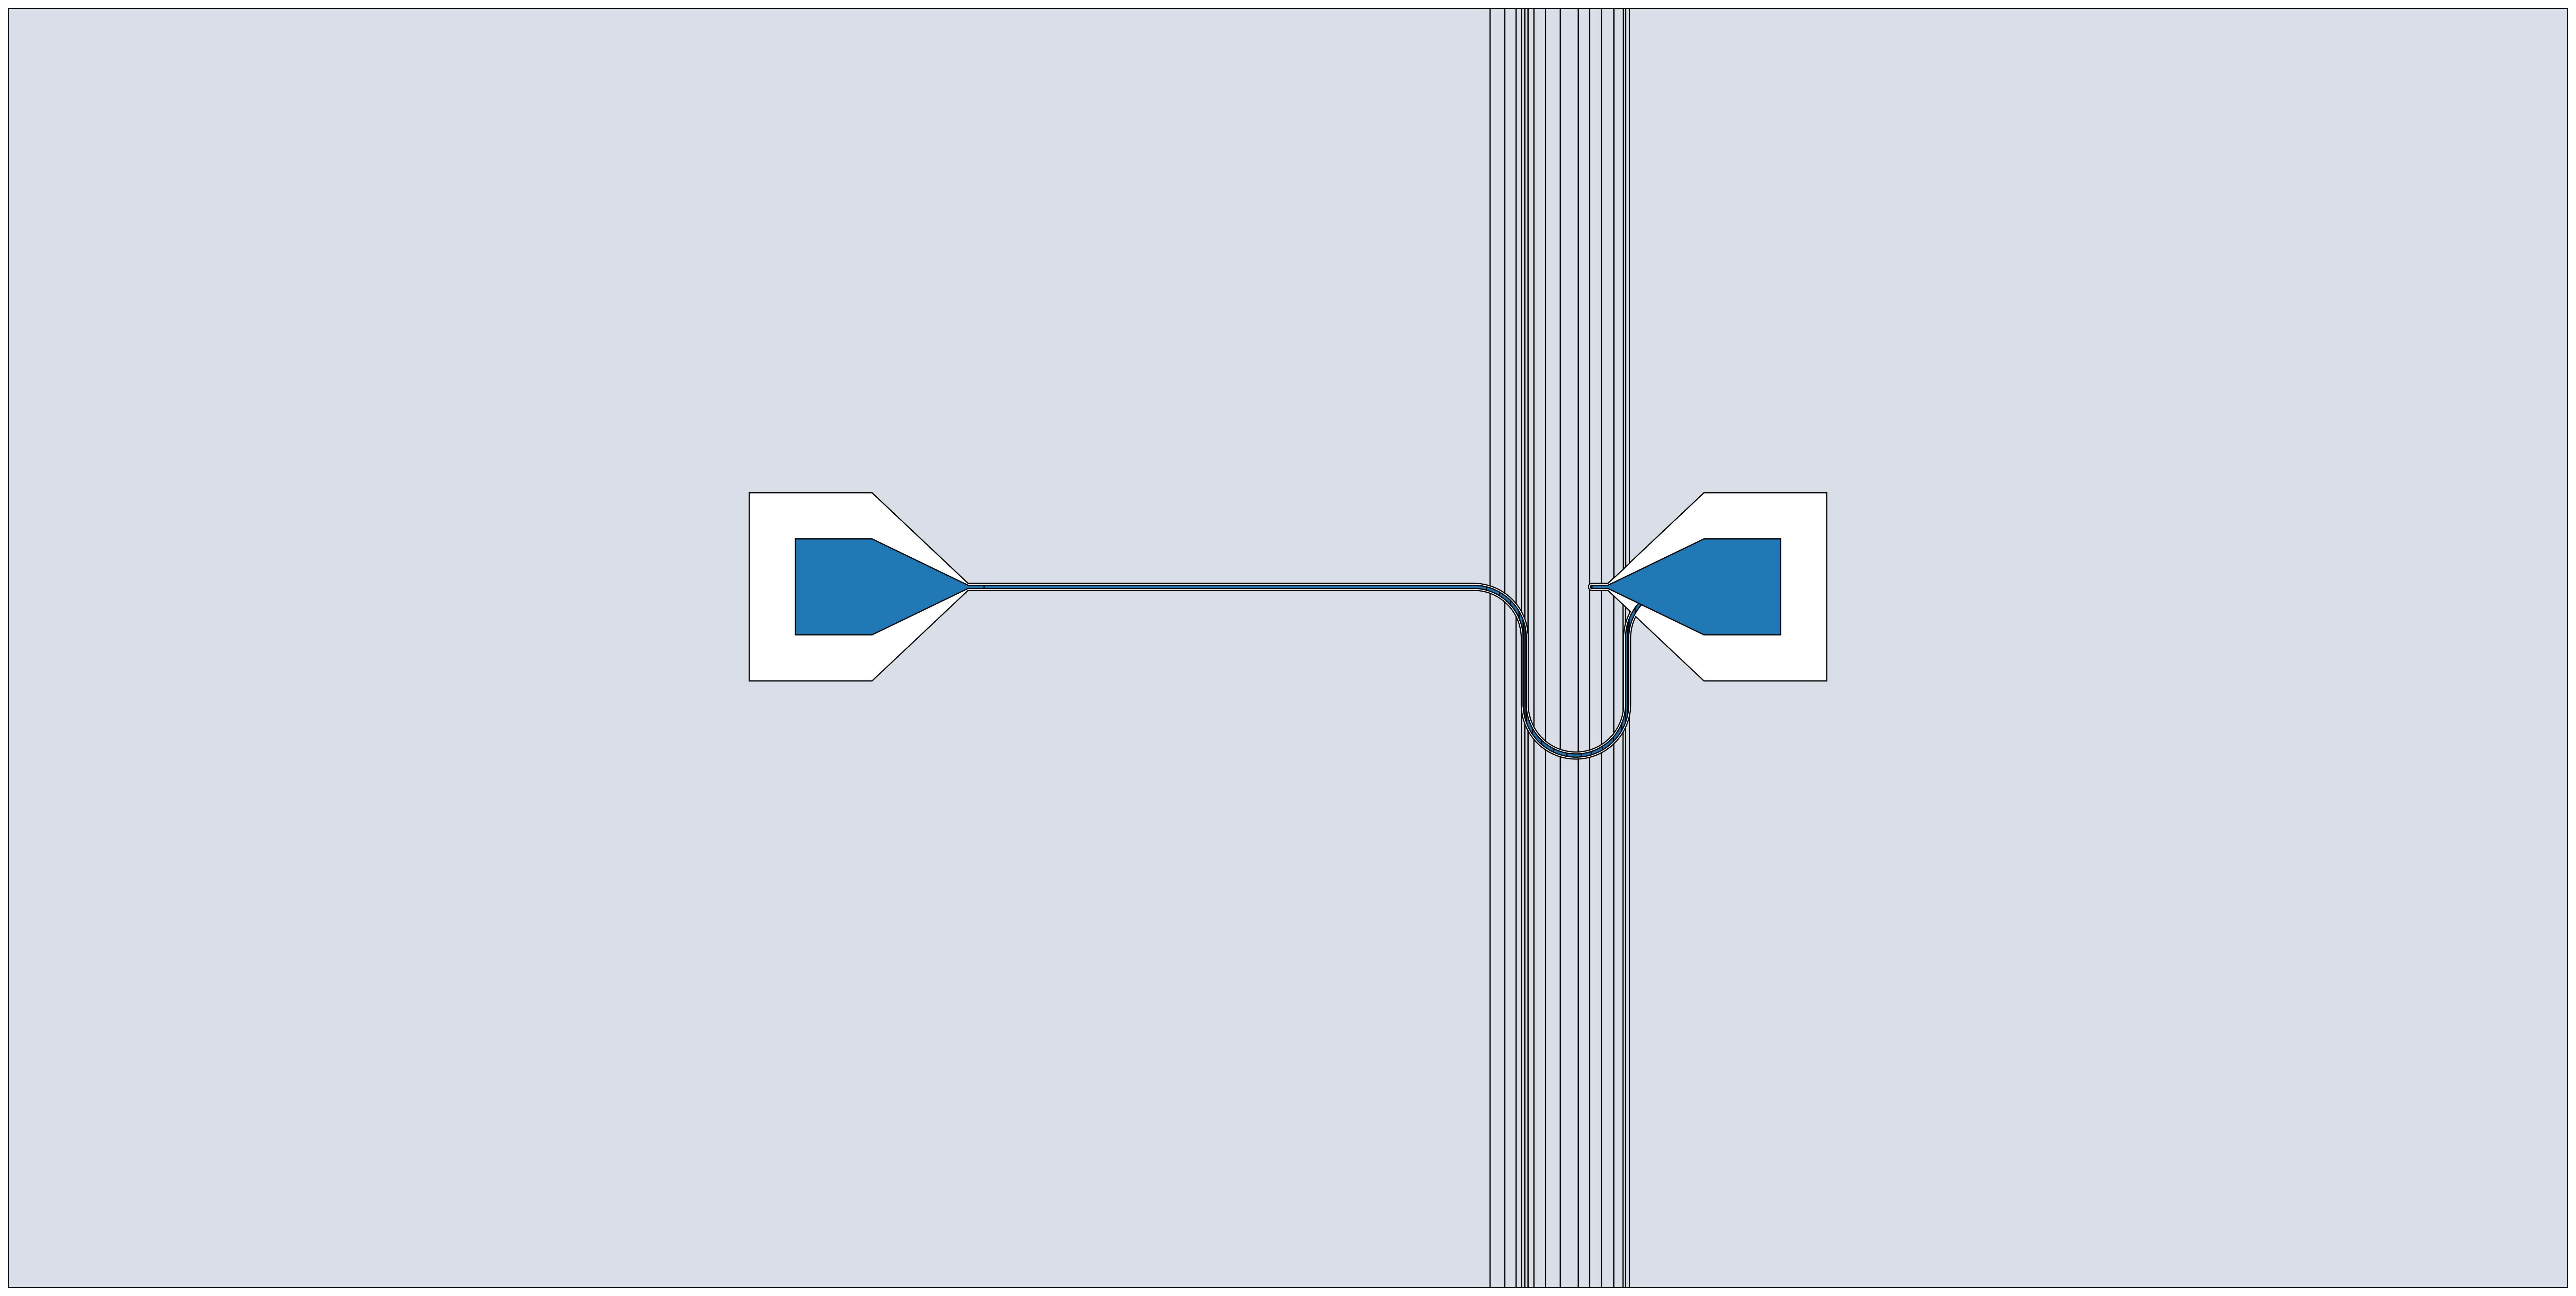

In [67]:
#@title Preview GDS inline
import os, glob, numpy as np, matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from IPython.display import display, Image
import gdstk

# ----- knobs you can tweak -----
GDS_PATH      = globals().get("GDS_OUT", "/content/meander_autofit.gds")  # reuse if set
TOP_CELL_NAME = globals().get("GDS_TOP_CELL", None)                                  # reuse if set
DPI           = 1200
FIG_WIDTH_IN  = 8.0
LINEWIDTH_PT  = 0.20
BG_COLOR      = "white"

# Layer colors (extend as needed)
LAYER_GROUND  = 2
LAYER_METAL   = 1
LAYER_COLOR   = {LAYER_GROUND: "#d9dee7", LAYER_METAL: "#1f77b4"}

def _pick_cell(lib, name=None):
    if name and name in [c.name for c in lib.cells]:
        print(f"[info] Using requested cell: {name}")
        return lib[name]
    tops = lib.top_level()
    if not tops:
        raise RuntimeError("No top-level cells in library.")
    print(f"[info] Auto-picked top cell: {tops[0].name}")
    return tops[0]

def _polys_by_layer(cell):
    # include_paths=True expands PATHs to polygons; apply_repetitions=True follows array/repetition
    polys = cell.get_polygons(apply_repetitions=True, include_paths=True, depth=None)
    by_layer, xs, ys = {}, [], []
    for p in polys:  # gdstk.Polygon objects
        layer = int(getattr(p, "layer", 0))
        pts = np.asarray(p.points, dtype=float)
        by_layer.setdefault(layer, []).append(pts)
        xs.append(pts[:, 0]); ys.append(pts[:, 1])
    if not xs:
        raise RuntimeError("Found no polygons to plot (empty cell?).")
    xs = np.concatenate(xs); ys = np.concatenate(ys)
    return by_layer, (float(xs.min()), float(ys.min()), float(xs.max()), float(ys.max()))

def save_and_show(gds_path, top_cell_name=None, dpi=DPI, fig_w_in=FIG_WIDTH_IN, lw_pt=LINEWIDTH_PT):
    if not os.path.exists(gds_path):
        # try last written .gds in /content
        cand = sorted(glob.glob("/content/*.gds"), key=os.path.getmtime)[-1:] or []
        if not cand:
            raise FileNotFoundError(f"GDS not found: {gds_path}")
        print(f"[warn] {gds_path} not found. Using most recent: {cand[0]}")
        gds_path = cand[0]

    print(f"[load] Reading: {gds_path}")
    lib  = gdstk.read_gds(gds_path)                                   # loads the library
    cell = _pick_cell(lib, top_cell_name)                              # choose cell
    by_layer, (minx, miny, maxx, maxy) = _polys_by_layer(cell)         # collect polys + bounds
    print(f"[info] Bounds (µm): x[{minx:.3f}, {maxx:.3f}], y[{miny:.3f}, {maxy:.3f}]")

    w_um = maxx - minx; h_um = maxy - miny
    aspect = w_um / max(h_um, 1e-12); fig_h_in = fig_w_in / aspect

    fig, ax = plt.subplots(figsize=(fig_w_in, fig_h_in), dpi=dpi)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(minx, maxx); ax.set_ylim(miny, maxy)
    ax.set_facecolor(BG_COLOR); ax.axis("off")

    # Draw ground first, then metal, then others for determinism
    draw_order = sorted(by_layer.keys(), key=lambda L: (L != LAYER_GROUND, L))
    for layer in draw_order:
        face = LAYER_COLOR.get(layer, "#666666")
        for pts in by_layer[layer]:
            ax.add_patch(MplPolygon(pts, closed=True, facecolor=face, edgecolor="black",
                                    linewidth=lw_pt, antialiased=True))

    root, _ = os.path.splitext(gds_path)
    out_png = f"{root}_preview_{dpi}dpi.png"
    out_pdf = f"{root}_preview.pdf"

    # Ensure renderer computes extents before saving
    fig.canvas.draw()
    fig.savefig(out_png, dpi=dpi, bbox_inches="tight", pad_inches=0.02)  # 600-DPI PNG
    fig.savefig(out_pdf,            bbox_inches="tight", pad_inches=0.02)  # vector PDF
    print(f"[ok] wrote PNG: {out_png}")
    print(f"[ok] wrote PDF: {out_pdf}")

    # Show inline in the notebook (forces frontend display)
    display(Image(filename=out_png))
    return out_png, out_pdf

png_path, pdf_path = save_and_show(GDS_PATH, top_cell_name=TOP_CELL_NAME)
